In [1]:
import os
from munch import Munch
from torch.backends import cudnn
import torch
from core.model import Generator,StyleEncoder,MappingNetwork


In [2]:
cudnn.benchmark = True
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def print_network(network):
    num_params = 0
    for p in network.parameters():
        num_params += p.numel()
    # print(network)
    print("Number of parameters of %s: %f w" % (network.__class__.__name__, num_params/10000.0))

In [4]:
img_size=256
style_dim=64
latent_dim=16
num_domains=3

generator = Generator(img_size, style_dim, w_hpf=0).to(device)
mapping_network = MappingNetwork(latent_dim, style_dim, num_domains).to(device)
style_encoder = StyleEncoder(img_size, style_dim, num_domains).to(device)

print_network(generator)
print_network(mapping_network)
print_network(style_encoder)

Number of parameters of Generator: 3389.299500 w
Number of parameters of MappingNetwork: 325.907200 w
Number of parameters of StyleEncoder: 2094.976000 w


In [5]:
module_dict = torch.load('./expr/checkpoints/afhq/100000_nets_ema.ckpt')
module_dict.keys()

dict_keys(['generator', 'mapping_network', 'style_encoder', 'fan'])

In [6]:
# load model weight
generator.load_state_dict(module_dict['generator'])
mapping_network.load_state_dict(module_dict['mapping_network'])
style_encoder.load_state_dict(module_dict['style_encoder'])

<All keys matched successfully>

In [59]:
# 均衡样本
from torch.utils.data.sampler import WeightedRandomSampler
import numpy as np
np.random.seed(99)
label = np.random.randint(0, 3, 10)
print("label: ", label)
class_count = np.bincount(label)
print("class count:", class_count)
class_weight = 1/class_count
print("class weight:", class_weight)
weight = class_weight[label]
print("weight correspons label:", weight)
# 按照 weight （作为采样的概率）， 从 [0, len(weight)-1] 取样，取样本数为 num_samples
sampler = WeightedRandomSampler(weights=weight, num_samples=10, replacement=True) # 重复取样 
print("sampler index: ", list(sampler))

label:  [1 1 0 1 0 2 0 1 0 1]
class count: [4 5 1]
class weight: [0.25 0.2  1.  ]
weight correspons label: [0.2  0.2  0.25 0.2  0.25 1.   0.25 0.2  0.25 0.2 ]
sampler index:  [2, 8, 3, 4, 9, 6, 4, 5, 8, 5]


In [86]:
# process img data
from torchvision.transforms import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize([img_size, img_size]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

def denormalize(x):
    """
    x shape: [B, C, H, W] in range [-1, 1]
    return [B, C, H, W] in range [0, 1]
    """
    out = (x + 1) / 2
    return out.clip_(0, 1)

src_demo: data/afhq/train/dog/flickr_dog_000725.jpg


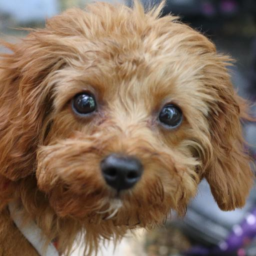

In [147]:
from pathlib import Path
import random
src_root = Path('./data/afhq/')
src_list = list(src_root.rglob("*.jpg"))
src_demo = random.choice(src_list)
print(f"src_demo: {src_demo}")
src = Image.open(src_demo)
src = transforms.Resize(img_size)(src)
src

torch.Size([1, 3, 256, 256])


Text(0.5, 1.0, 'target')

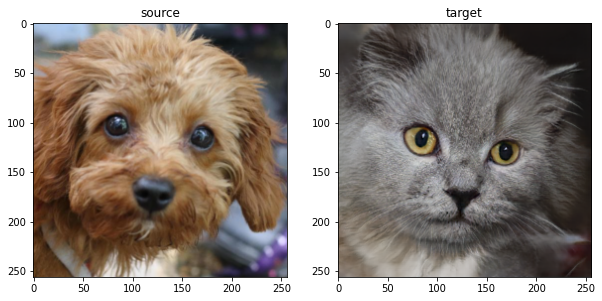

In [224]:
# generate from latent code
import matplotlib.pyplot as plt
z1 = torch.randn(1, latent_dim).to(device)
y1 = torch.tensor([0]).to(device) # 0: cat, 1: dog 2: wild
s = mapping_network(z1, y1)
src_tensor = transform(src).unsqueeze(0).to(device)
fake_tensor = generator(src_tensor, s)
print(fake_tensor.shape)
fake = transforms.ToPILImage()(denormalize(fake_tensor).squeeze().to('cpu'))

fig = plt.figure(figsize=(10, 15))
plt.subplot(1, 2, 1)
plt.imshow(src)
plt.title("source")
plt.subplot(1, 2, 2)
plt.imshow(fake)
plt.title("target")


data/afhq/val/wild/pixabay_wild_000470.jpg
torch.Size([1, 3, 256, 256])


Text(0.5, 1.0, 'target')

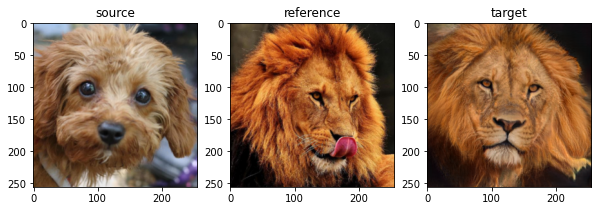

In [229]:
# generate from reference img
import matplotlib.pyplot as plt

ref_domain = 2
domain_map = {0: "cat", 1: "dog", 2: "wild"}
ref_img_list = list(Path(f'./data/afhq/val/{domain_map[ref_domain]}/').glob('*.jpg'))

ref_img_path = random.choice(ref_img_list)
print(ref_img_path)
ref_img_tensor = transform(Image.open(ref_img_path)).to(device)
ref_img = transforms.ToPILImage()(denormalize(ref_img_tensor.cpu()))

s = style_encoder(ref_img_tensor.unsqueeze(0), torch.tensor(ref_domain).unsqueeze(0).to(device))
src_tensor = transform(src).unsqueeze(0).to(device)
fake_tensor = generator(src_tensor, s)
print(fake_tensor.shape)
fake = transforms.ToPILImage()(denormalize(fake_tensor).squeeze().to('cpu'))

fig = plt.figure(figsize=(10, 15))
plt.subplot(1, 3, 1)
plt.imshow(src)
plt.title("source")
plt.subplot(1, 3, 2)
plt.imshow(ref_img)
plt.title("reference")
plt.subplot(1, 3, 3)
plt.imshow(fake)
plt.title("target")